In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Do not print file paths
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import torch
import torch.nn as nn

class MSE(torch.nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        self.squared_difference = torch.nn.MSELoss(reduction='none')

    def forward(self, X, Y):
        return torch.mean(self.squared_difference(X, Y))

# 定义深度自编码器模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # 将全连接层替换为 Conv2d
        self.fc = nn.Conv2d(64, 16, kernel_size=1)  # 保持输出维度为 8*8*16

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # 定义自定义MSE损失
        self.mse_loss = MSE()

    def forward(self, x):
        encoded = self.encoder(x)
        # 使用 Conv2d 代替全连接层
        encoded = self.fc(encoded)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 打印模型结构
autoencoder = Autoencoder()
print(autoencoder)
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 使用Kaggle GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义数据集和数据加载器
dataset = datasets.ImageFolder('/kaggle/input/dogs-dataset1/Stanford Dogs Dataset_images_datasets',
                               transform=transforms.Compose([
                                   transforms.Resize((64, 64)),
                                   transforms.ToTensor(),
                               ]))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

# 初始化模型、损失函数和优化器
autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# 模型训练
num_epochs = 10
for epoch in range(num_epochs):
    for data, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        # 前向传播
        _, outputs = autoencoder(data)
        loss = autoencoder.mse_loss(outputs, data)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# 保存模型
torch.save(autoencoder.state_dict(), '/kaggle/working/autoencoder.pth')



Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
  (mse_loss): MSE(
    (squared_difference): MSELoss()
  )
)
Epoch [1/10], Loss: 0.0104
Epoch [2/10], Loss: 0.0087
Epoch [3/10], Loss: 0.0086
Epoch [4/10], Loss: 0.0061
Epoch [5/10], Loss: 0.0053
Epoch [6/10], Loss: 0.0040
Epoch

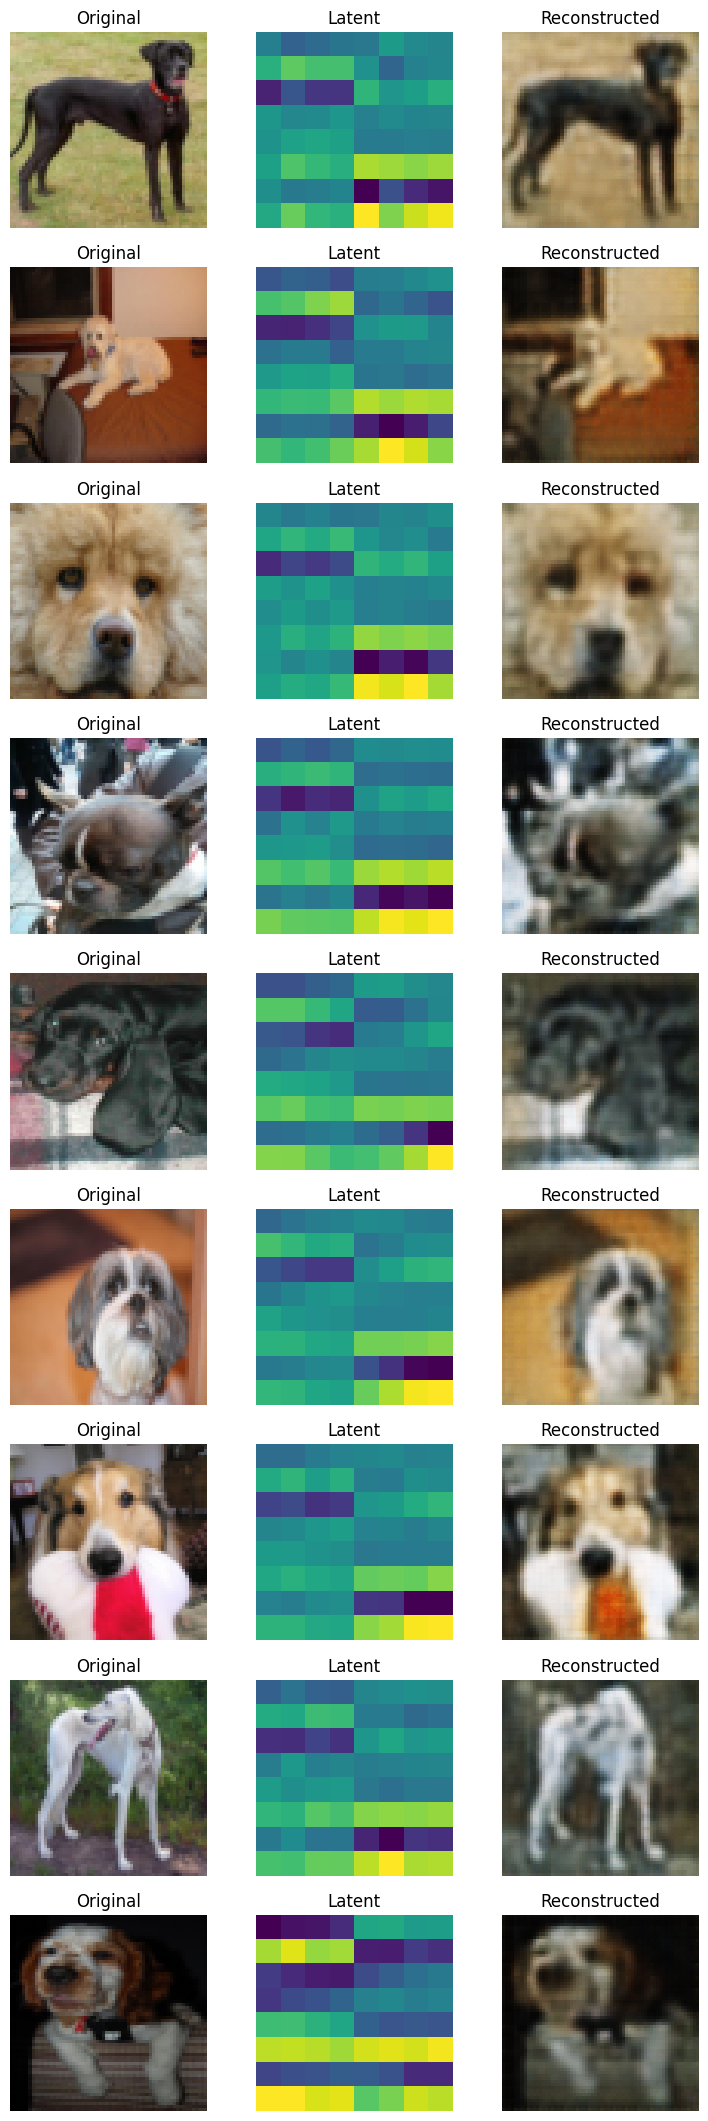

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 从数据加载器中随机选择9张图片
data_iter = iter(dataloader)
images, _ = next(data_iter)
images = images.to(device)

# 获取重建图像和latent code
with torch.no_grad():
    _, reconstructed_images = autoencoder(images)
    encoded_images, _ = autoencoder(images)

# 将图像从Tensor转换为NumPy数组
images = images.cpu().numpy()
reconstructed_images = reconstructed_images.cpu().numpy()

# 可视化原图、latent code和重建图像，每组按行展示
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(9, 27))

for i in range(9):
    # 展示原图
    axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # 展示latent code
    axes[i, 1].imshow(encoded_images[i].view(-1).cpu().numpy().reshape(8, 8, -1).mean(axis=(2)), cmap='viridis')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Latent')

    # 展示重建图像
    axes[i, 2].imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Reconstructed')

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


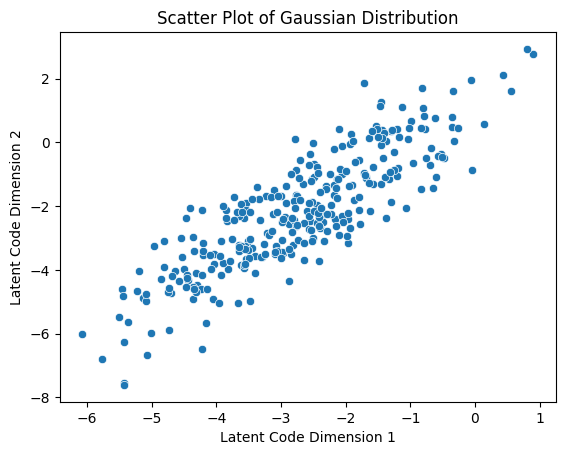

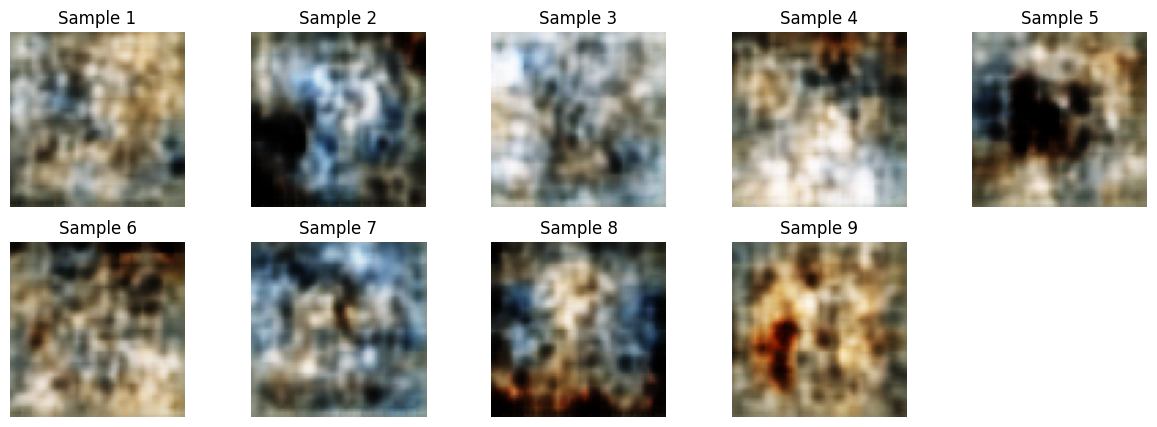

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 加载数据集
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder('/kaggle/input/dogs-dataset1/Stanford Dogs Dataset_images_datasets',
                               transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2)

# 初始化模型Q
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('/kaggle/working/autoencoder.pth'))
autoencoder.eval()

# 获取所有图像对应的latent code
all_latent_codes = []

with torch.no_grad():
    for data, _ in dataloader:
        data = data.to(device)
        encoded_images, _ = autoencoder(data)
        all_latent_codes.append(encoded_images.view(encoded_images.size(0), -1).cpu().numpy())

# 将所有latent code合并为一个数组
all_latent_codes = np.concatenate(all_latent_codes, axis=0)

# 计算latent code的统计特性                               
latent_mean = np.mean(all_latent_codes, axis=0)
latent_cov = np.cov(all_latent_codes, rowvar=False)

# 构造高斯分布并进行采样
latent_distribution = np.random.multivariate_normal(latent_mean, latent_cov, size=300)

# 绘制散点图
sns.scatterplot(x=latent_distribution[:, 0], y=latent_distribution[:, 1])
plt.title('Scatter Plot of Gaussian Distribution')
plt.xlabel('Latent Code Dimension 1')
plt.ylabel('Latent Code Dimension 2')
plt.show()

# 将高斯分布的样本送入decoder并显示生成的图像
with torch.no_grad():
    generated_images = autoencoder.decoder(torch.tensor(latent_distribution, dtype=torch.float32).to(device).view(-1, 16, 8, 8))

# 可视化生成的图像
plt.figure(figsize=(15, 5))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(generated_images[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Sample {i + 1}')

plt.show()


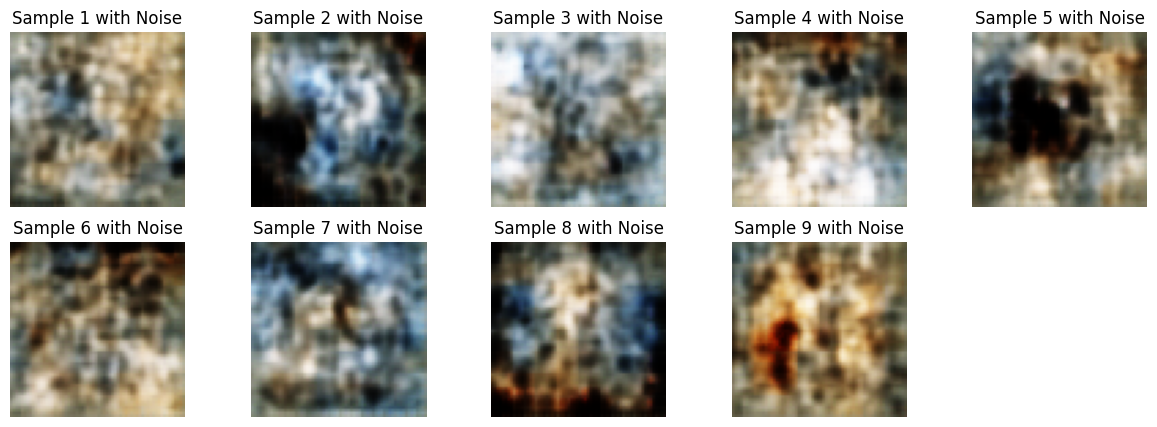

In [16]:
# 为每个样本生成随机高斯噪声
noise_stddev = 0.2
latent_code_with_noise = latent_distribution + np.random.normal(0, noise_stddev, size=latent_distribution.shape)

# 将扰动后的 latent code 送入 decoder
with torch.no_grad():
    generated_images_with_noise = autoencoder.decoder(torch.tensor(latent_code_with_noise, dtype=torch.float32).to(device).view(-1, 16, 8, 8))

# 可视化生成的图像
plt.figure(figsize=(15, 5))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(generated_images_with_noise[i].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Sample {i + 1} with Noise')

plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.metrics import peak_signal_noise_ratio
import numpy as np

# 自定义带噪声的正则自编码器模型
class RegularizedAutoencoder(nn.Module):
    def __init__(self, latent_size):
        super(RegularizedAutoencoder, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # 将全连接层替换为 Conv2d
        self.fc = nn.Conv2d(64, latent_size, kernel_size=1)  # 保持输出维度为 8*8*16

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        # 使用 Conv2d 代替全连接层
        encoded = self.fc(encoded)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 计算功率归一化
def power_normalize(latent_code):
    norm_factor = np.sqrt(np.mean(latent_code ** 2))
    normalized_latent_code = latent_code / norm_factor
    return normalized_latent_code

# 训练带噪声的正则自编码器
def train_regularized_autoencoder(latent_size, noise_stddev, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载数据集
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
    dataset = datasets.ImageFolder('/kaggle/input/dogs-dataset1/Stanford Dogs Dataset_images_datasets',
                                   transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

    # 初始化模型、损失函数和优化器
    autoencoder = RegularizedAutoencoder(latent_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # 训练模型
    for epoch in range(num_epochs):
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()

            # 前向传播
            _, outputs = autoencoder(data)

            # 计算损失
            loss = criterion(outputs, data)

            # 反向传播和优化
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # 测试模型
    with torch.no_grad():
        total_psnr = 0.0
        num_samples = 0
        for data, _ in dataloader:
            data = data.to(device)

            # 获取原始图像的 PSNR
            original_psnr = peak_signal_noise_ratio(data.cpu().numpy(), data.cpu().numpy())

            # 加入零均值高斯噪声
            noise = torch.randn_like(data) * noise_stddev
            data_with_noise = data + noise

            # 传递数据通过模型获取重构图像
            _, outputs = autoencoder(data_with_noise)

            # 获取重构图像的 PSNR
            reconstructed_psnr = peak_signal_noise_ratio(data.cpu().numpy(), outputs.cpu().numpy())

            total_psnr += reconstructed_psnr
            num_samples += data.size(0)

            print(f'Original PSNR: {original_psnr:.4f}, Reconstructed PSNR: {reconstructed_psnr:.4f}')

        average_psnr = total_psnr / num_samples
        print(f'Average PSNR: {average_psnr:.4f}')

# 试验不同噪声方差下的效果
latent_size = 8 * 8 * 16
noise_stddevs = [0.05, 0.1, 0.15]

for stddev in noise_stddevs:
    print(f"\nTraining with noise stddev={stddev}")
    train_regularized_autoencoder(latent_size, stddev)



Training with noise stddev=0.05
Epoch [1/10], Loss: 0.0059
Epoch [2/10], Loss: 0.0050
Epoch [3/10], Loss: 0.0031
Epoch [4/10], Loss: 0.0024
Epoch [5/10], Loss: 0.0023
Epoch [6/10], Loss: 0.0029
Epoch [7/10], Loss: 0.0023
Epoch [8/10], Loss: 0.0019
Epoch [9/10], Loss: 0.0017
Epoch [10/10], Loss: 0.0017


/opt/conda/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


Original PSNR: inf, Reconstructed PSNR: 26.8817
Original PSNR: inf, Reconstructed PSNR: 26.9393
Original PSNR: inf, Reconstructed PSNR: 26.5676
Original PSNR: inf, Reconstructed PSNR: 26.9168
Original PSNR: inf, Reconstructed PSNR: 27.3227
Original PSNR: inf, Reconstructed PSNR: 27.2604
Original PSNR: inf, Reconstructed PSNR: 27.0454
Original PSNR: inf, Reconstructed PSNR: 27.0529
Original PSNR: inf, Reconstructed PSNR: 27.2851
Original PSNR: inf, Reconstructed PSNR: 27.1921
Original PSNR: inf, Reconstructed PSNR: 26.8897
Original PSNR: inf, Reconstructed PSNR: 27.4135
Original PSNR: inf, Reconstructed PSNR: 27.2246
Original PSNR: inf, Reconstructed PSNR: 26.8579
Original PSNR: inf, Reconstructed PSNR: 26.6886
Original PSNR: inf, Reconstructed PSNR: 26.7387
Original PSNR: inf, Reconstructed PSNR: 27.2034
Original PSNR: inf, Reconstructed PSNR: 26.6328
Original PSNR: inf, Reconstructed PSNR: 27.1727
Original PSNR: inf, Reconstructed PSNR: 27.2964
Original PSNR: inf, Reconstructed PSNR: 